In [58]:
import torch
from diffusers import FluxPipeline

pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16, device_map="cuda:0")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading pipeline components...: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


In [59]:
torch.set_grad_enabled(False)

In [60]:
from collections import OrderedDict
for m in pipe.transformer.modules():
    m._forward_hooks = OrderedDict()
pipe.transformer.transformer_blocks[18].register_forward_hook(lambda self, input, output: print(output[0].shape, output[1].shape))
height = 512
width = 512
prompt = "A cat holding a sign that says hello world"
latents = pipe(
    prompt,
    height=height,
    width=width,
    guidance_scale=3.5,
    num_inference_steps=1,
    max_sequence_length=512,
    generator=torch.Generator("cpu").manual_seed(0),
    return_dict=False,
    callback_on_step_end=lambda *args, **kwargs: print(args, kwargs.keys()) or {},
    output_type="latent"
)[0]

100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

torch.Size([1, 512, 3072]) torch.Size([1, 1024, 3072])
(FluxPipeline {
  "_class_name": "FluxPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "black-forest-labs/FLUX.1-schnell",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}
, 0, tensor(1000., device='cuda:3'), {'latents': tensor([[[-0.1406,  0.1729, -0.1836,  ...,  1.6406,  1.5312,  1.8438],
         [ 0.3047,  0.0859,  0.1328,  ...,  1.5469,  1.5859,  1.7344],
         [ 0.1504, -0.1641,  0.1816,  ...,  1.2344,  1.5938,

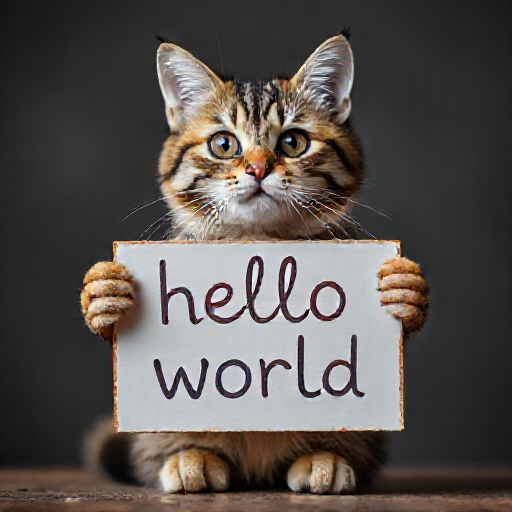

In [61]:
latents_reshaped = pipe._unpack_latents(latents, height, width, pipe.vae_scale_factor)
latents_reshaped = (latents_reshaped / pipe.vae.config.scaling_factor) + pipe.vae.config.shift_factor
image = pipe.vae.decode(latents_reshaped, return_dict=False)[0]
image = pipe.image_processor.postprocess(image, output_type="pil")
image[0]

In [67]:
import numpy as np
nf4 = np.asarray(
    [
        -1.0,
        -0.6961928009986877,
        -0.5250730514526367,
        -0.39491748809814453,
        -0.28444138169288635,
        -0.18477343022823334,
        -0.09105003625154495,
        0.0,
        0.07958029955625534,
        0.16093020141124725,
        0.24611230194568634,
        0.33791524171829224,
        0.44070982933044434,
        0.5626170039176941,
        0.7229568362236023,
        1.0,
    ]
)
image_max = 6.0

In [66]:
from collections import OrderedDict
from datasets import load_dataset
from more_itertools import chunked
from itda import ITDAConfig, ITDA
import json, os
os.makedirs("dataset", exist_ok=True)
prompts_dataset = load_dataset("opendiffusionai/cc12m-cleaned")
prompts_iterator = prompts_dataset["train"]["caption_llava_short"]
guidance_scale = 3.5
num_inference_steps = 6
batch_size = 16
width = 512
height = 512
d_model = 3072
itda_config = ITDAConfig(
    d_model=d_model,
    target_l0=64,
    loss_threshold=0.8,
    add_error=False,
    subtract_mean=False,
)
itda = ITDA(itda_config).to(torch.bfloat16).to("cuda:0")
for i, prompts in enumerate(chunked(prompts_iterator, batch_size)):
    with torch.inference_mode():
        for m in pipe.transformer.modules():
            m._forward_hooks = OrderedDict()
        layer_outputs = {}
        timestep = 0
        def save_hook(self, input, output):
            layer_outputs[timestep] = output[0]
        pipe.transformer.transformer_blocks[18].register_forward_hook(save_hook)
        height = 512
        width = 512
        def callback_on_step_end(self, i, t, kwargs):
            global timestep
            timestep = i
            return {}
        latents = pipe(
            prompts,
            height=height,
            width=width,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            max_sequence_length=512,
            generator=torch.Generator("cpu").manual_seed(0),
            return_dict=False,
            callback_on_step_end=callback_on_step_end,
            output_type="latent"
        )[0]
        latents_reshaped = pipe._unpack_latents(latents, height, width, pipe.vae_scale_factor)
        latents_to_be_compressed = latents_reshaped.cpu().float().numpy()
        latents_to_save = (latents_to_be_compressed / image_max).clip(-1, 1)
        latents_to_save = np.abs(latents_to_save[..., None] - nf4).argmin(-1).astype(np.uint8)
        latents_to_save = (
            (latents_to_save[..., ::2] & 0x0F)
            | ((latents_to_save[..., 1::2] << 4) & 0xF0))
        np.savez_compressed(f"dataset/batch-{i}.npz", latents_to_save)
        json.dump(dict(
            prompts=prompts,
            step=i,
            batch_size=batch_size,
            width=width,
            height=height,
            guidance_scale=3.5,
            num_inference_steps=num_inference_steps,
        ), open(f"dataset/batch-{i}.json", "w"))
    break

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


tensor(-4.5625, device='cuda:3', dtype=torch.bfloat16) tensor(5.2500, device='cuda:3', dtype=torch.bfloat16) tensor(-0.0371, device='cuda:3', dtype=torch.bfloat16) tensor(1.1172, device='cuda:3', dtype=torch.bfloat16)
